# DM-31046 Zooniverse cutouts

This notebook is to try out the `ZoonverseCutoutsTask` implemented on DM-31046. The notebook may evolve as that task is improved (i.e. to include source selection via sql query) on a subsequent ticket.

In [1]:
import glob
import os
import pandas as pd
import sqlite3

import IPython.display

import lsst.daf.persistence
from lsst.pipe.tasks.zooniverseCutouts import ZooniverseCutoutsTask

# local to ap_pipe-notebooks
import apdbPlots

In [2]:
# The gen2 butler repos containing the templates and difference images, respectively.
parent = "/project/sullivan/saha/cwcoadds_processed"
REPO = '/project/sullivan/saha/ap_pipe/cw/'

In [3]:
# The URL where the output files can be accessed by zooniverse.
url_root = "https://lsst.ncsa.illinois.edu/~parejkoj/zooniverse/"
# The path to write the PNG and manifest files to.
output_path = "/scratch/parejkoj/zooniverse/"

## Load sources from apdb

In [4]:
connection = sqlite3.connect(f'{REPO}/association.db')

In [5]:
butler = lsst.daf.persistence.Butler(inputs=[REPO, parent])

<ipython-input-5-af21186712fe>:1: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = lsst.daf.persistence.Butler(inputs=[REPO, parent])
<ipython-input-5-af21186712fe>:1: FutureWarning: Gen2 Butler has been deprecated (DecamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = lsst.daf.persistence.Butler(inputs=[REPO, parent])


In [6]:
%%time 
# to get a random sample: ORDER BY RANDOM() 
sources = pd.read_sql_query('select * from DiaSource LIMIT 100;', connection)

CPU times: user 14.1 ms, sys: 232 µs, total: 14.4 ms
Wall time: 11.9 ms


In [12]:
# NOTE: need to run this to add ccd and visit identifiers to the sources.
# Apdb doesn't have another way to get those, and they are necessary for retrieving the images.
apdbPlots.addVisitCcdToSrcTable(sources)

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,extendedness,spuriousness,flags,pixelId,filterName,filterId,isDipole,bboxSize,ccd,visit
0,184157035032479591,42877401,184157035032479591,0,0,0,None,57116.286309,270.371311,None,...,None,None,25299404,0,g,1,0,33,01,428774
1,184157035032479592,42877401,184157035032479592,0,0,0,None,57116.286309,270.370908,None,...,None,None,31066572,0,g,1,0,36,01,428774
2,184157035032479593,42877401,184157035032479593,0,0,0,None,57116.286309,270.372414,None,...,None,None,25168328,0,g,1,0,48,01,428774
3,184157035032479594,42877401,184157035032479594,0,0,0,None,57116.286309,270.370768,None,...,None,None,31066600,0,g,1,0,26,01,428774
4,184157035032479595,42877401,184157035032479595,0,0,0,None,57116.286309,270.370701,None,...,None,None,31066568,0,g,1,0,17,01,428774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,184157035032479686,42877401,184157035032479686,0,0,0,None,57116.286309,270.390668,None,...,None,None,25165864,0,g,1,0,15,01,428774
96,184157035032479687,42877401,184157035032479687,0,0,0,None,57116.286309,270.390280,None,...,None,None,41944360,0,g,1,1,21,01,428774
97,184157035032479688,42877401,184157035032479688,0,0,0,None,57116.286309,270.390002,None,...,None,None,1320,0,g,1,0,14,01,428774
98,184157035032479689,42877401,184157035032479689,0,0,0,None,57116.286309,270.390061,None,...,None,None,25167144,0,g,1,0,16,01,428774


## Use the above selected sources to make cutouts

In [8]:
config = ZooniverseCutoutsTask.ConfigClass()
config.urlRoot = url_root
config.outputPath = output_path
zooniverseCutouts = ZooniverseCutoutsTask(config)

In [9]:
%%time
zooniverseCutouts.generate_images(sources, butler)

CacheInfo(hits=99, misses=1, maxsize=16, currsize=1)
CPU times: user 23.4 s, sys: 8.93 s, total: 32.3 s
Wall time: 32.6 s


NOTE: `generate_images` took about 3.5 minutes on 100 sources without the lru_cache, vs. about 30 seconds with the cache on (and all 100 sources were on the same detector/visit).

In [10]:
manifest = zooniverseCutouts.make_manifest(sources)
manifest.to_csv(os.path.join(config.outputPath, "manifest.csv"), index=False)

## Display some images

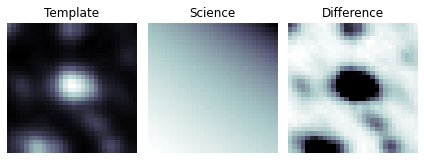

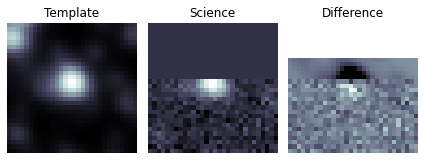

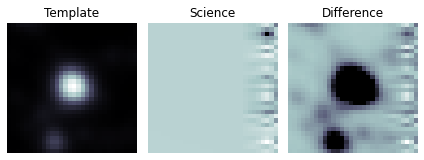

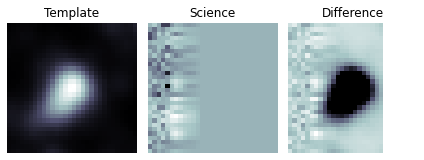

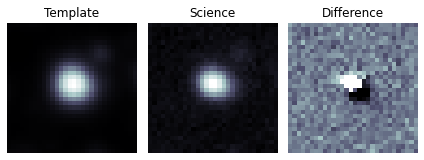

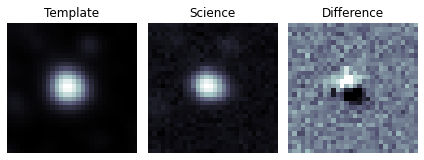

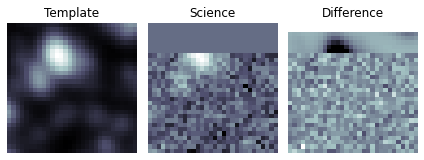

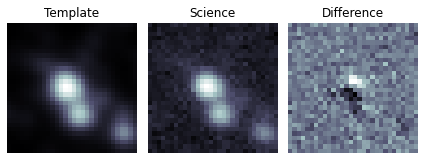

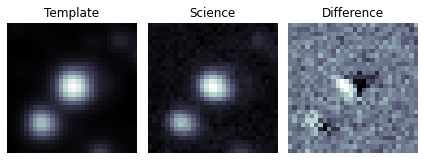

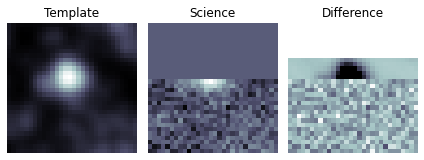

In [11]:
files = glob.glob(os.path.join(config.outputPath, "images", "*.png"))
for file in files[:10]:
    image = IPython.display.Image(file)
    IPython.display.display(image)